<a href="https://colab.research.google.com/github/ooishe/CVPR/blob/main/Mid/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification: Comparison of Manhattan (L1) and Euclidean (L2) Distances

# Libraries and drive mounting

In [56]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [57]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset and Preprocessing


The dataset contains 300 training images across 3 classes, resized to 32x32 grayscale pixels for efficient k-NN classification using Manhattan (L1) and Euclidean (L2) distances with 5-fold cross-validation

In [58]:
def load_images(root):
    X = []
    y = []
    class_names = sorted(os.listdir(root))

    for label, cls in enumerate(class_names):
        cls_path = os.path.join(root, cls)

        for file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (32,32))

            X.append(gray.flatten())
            y.append(label)

    return np.array(X), np.array(y), class_names


X, y, class_names = load_images("/content/drive/MyDrive/animal_dataset")

print("Classes found:", class_names)
print("Data loaded:", X.shape, y.shape)


Classes found: ['cat', 'dog', 'panda']
Data loaded: (300, 1024) (300,)


# Model Building

To evaluate the performance of k-NN classifiers with different distance metrics and K values, performed 5-fold cross-validation. Computed the average accuracy across folds for each combination of K and distance metric (Manhattan/L1 and Euclidean/L2) to assess model performance in a robust manner

In [59]:
K_list = [1,2,3,4,5,6,7,8,9,10,11,12,13]

distance_options = ["manhattan", "euclidean"]

cv_summary = {dist: [] for dist in distance_options}

fold_details = {dist: {k: [] for k in K_list} for dist in distance_options}

splitter = KFold(n_splits=5, shuffle=True, random_state=42)

print("---- Running 5-Fold Cross Validation ----")

for dist in distance_options:
    print(f"\n>>> Evaluating using {dist.upper()} distance")

    for k_value in K_list:
        fold_scores = []

        for train_idx, test_idx in splitter.split(X):
            trX, teX = X[train_idx], X[test_idx]
            trY, teY = y[train_idx], y[test_idx]

            model = KNeighborsClassifier(
                n_neighbors=k_value,
                metric=dist
            )

            model.fit(trX, trY)
            accuracy = model.score(teX, teY)

            fold_scores.append(accuracy)

        fold_details[dist][k_value] = fold_scores
        avg_acc = np.mean(fold_scores)
        cv_summary[dist].append(avg_acc)

        print(f"K = {k_value:2d} | fold accuracies: {fold_scores} | avg = {avg_acc:.4f}")


---- Running 5-Fold Cross Validation ----

>>> Evaluating using MANHATTAN distance
K =  1 | fold accuracies: [0.4, 0.35, 0.38333333333333336, 0.2833333333333333, 0.4166666666666667] | avg = 0.3667
K =  2 | fold accuracies: [0.38333333333333336, 0.38333333333333336, 0.31666666666666665, 0.21666666666666667, 0.43333333333333335] | avg = 0.3467
K =  3 | fold accuracies: [0.35, 0.4166666666666667, 0.4, 0.36666666666666664, 0.45] | avg = 0.3967
K =  4 | fold accuracies: [0.38333333333333336, 0.4166666666666667, 0.3, 0.3333333333333333, 0.4] | avg = 0.3667
K =  5 | fold accuracies: [0.35, 0.45, 0.36666666666666664, 0.31666666666666665, 0.36666666666666664] | avg = 0.3700
K =  6 | fold accuracies: [0.35, 0.5333333333333333, 0.35, 0.3333333333333333, 0.38333333333333336] | avg = 0.3900
K =  7 | fold accuracies: [0.3333333333333333, 0.4666666666666667, 0.4, 0.3333333333333333, 0.38333333333333336] | avg = 0.3833
K =  8 | fold accuracies: [0.35, 0.55, 0.43333333333333335, 0.26666666666666666, 0.

# Result & Analysis

Plotted the average accuracy against different K values for both Manhattan and Euclidean distances

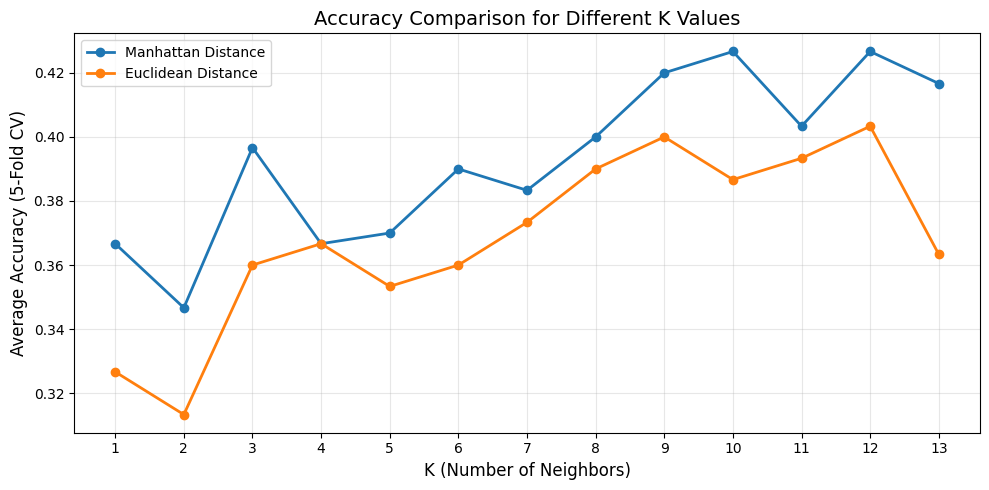

In [60]:
plt.figure(figsize=(10,5))

for dist in distance_options:
    plt.plot(
        K_list,
        cv_summary[dist],
        marker="o",
        linewidth=2,
        label=f"{dist.capitalize()} Distance"
    )

plt.title("Accuracy Comparison for Different K Values", fontsize=14)
plt.xlabel("K (Number of Neighbors)", fontsize=12)
plt.ylabel("Average Accuracy (5-Fold CV)", fontsize=12)
plt.xticks(K_list)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Discussion

Based on the highest mean cross-validation accuracy, selected the best K value for each distance metric. We then identify which distance metric achieves the highest overall accuracy

In [61]:
best_K_per_metric = {}

for dist in distance_options:
    accuracies = cv_summary[dist]
    max_idx = np.argmax(accuracies)
    best_K = K_list[max_idx]
    best_acc = accuracies[max_idx]
    best_K_per_metric[dist] = (best_K, best_acc)
    print(f"Best K for {dist.capitalize()} distance: {best_K} (Avg Accuracy: {best_acc:.4f})")


Best K for Manhattan distance: 10 (Avg Accuracy: 0.4267)
Best K for Euclidean distance: 12 (Avg Accuracy: 0.4033)


In [62]:
best_metric = max(best_K_per_metric.items(), key=lambda x: x[1][1])

print("\n=== Overall Best Metric ===")
print(f"{best_metric[0].capitalize()} distance performs best with K = {best_metric[1][0]} achieving average accuracy = {best_metric[1][1]:.4f}")



=== Overall Best Metric ===
Manhattan distance performs best with K = 10 achieving average accuracy = 0.4267


In [63]:
train_acc = model.score(X, y)
print("Training accuracy of final model:", train_acc)

y_pred = model.predict(X)
print(classification_report(y, y_pred, target_names=class_names))

Training accuracy of final model: 0.48333333333333334
              precision    recall  f1-score   support

         cat       0.49      0.62      0.55       100
         dog       0.44      0.70      0.54       100
       panda       0.87      0.13      0.23       100

    accuracy                           0.48       300
   macro avg       0.60      0.48      0.44       300
weighted avg       0.60      0.48      0.44       300



# Top 5 Predictions

To evaluate the trained model qualitatively, randomly five images from the dataset are displayed  along with their true and predicted class labels.

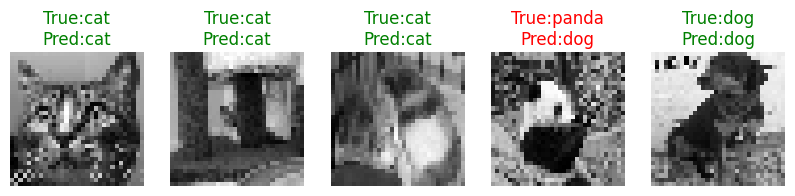

In [64]:
np.random.seed(37)
idxs = np.random.choice(len(X), size=5, replace=False)

plt.figure(figsize=(10, 3))

img_size = 32

for j, i in enumerate(idxs):
    pred_label = model.predict(X[i].reshape(1, -1))[0]
    true_class = class_names[y[i]]
    pred_class = class_names[pred_label]

    img = X[i].reshape(img_size, img_size)

    plt.subplot(1, 5, j+1)
    plt.imshow(img, cmap="gray")
    color = 'green' if true_class == pred_class else 'red'
    plt.title(f"True:{true_class}\nPred:{pred_class}", color= color)
    plt.axis("off")

plt.show()